In [30]:
import jax
import jax.numpy as jnp


train_x = jnp.array([-0.8, -0.75, 0.0, 0.05, 0.07, 0.7, 0.73])
train_y = jnp.cos(train_x)**2 + 0.01*jax.random.normal(jax.random.PRNGKey(0), train_x.shape)

In [31]:
polyfit_coeffs = jnp.polyfit(train_x, train_y, deg=3)
eval_x = jnp.linspace(-1, 1, 1000)

def evaluate(polyfit_coeffs, x):
    return jnp.polyval(polyfit_coeffs, x)

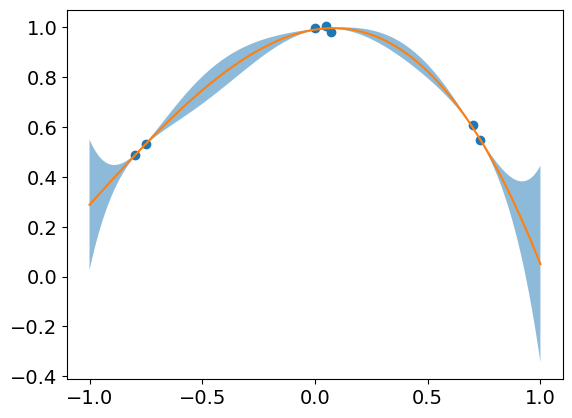

In [32]:
import matplotlib.pyplot as plt

eval_y_pol = evaluate(polyfit_coeffs, eval_x)

plt.plot(train_x, train_y, "o")
plt.plot(eval_x, eval_y_pol)

X = jnp.vander(train_x, N=4)
XTX = X.T @ X

gradients = jax.jacrev(evaluate)(polyfit_coeffs, eval_x)

def calculate_uncertainties(XTX, gradients):
    return gradients @ jnp.linalg.solve(XTX, gradients)

uncertainties_pol = 0.005 * jax.vmap(calculate_uncertainties, in_axes=(None, 0))(XTX, gradients)

plt.fill_between(eval_x, eval_y_pol - uncertainties_pol, eval_y_pol + uncertainties_pol, alpha=0.5)

plt.show()

In [33]:
def gaussian(params, x):
    a, b, c, d, e, f = params
    return a * jnp.exp(-((x - b) / c)**2) + d * jnp.exp(-((x - e) / f)**2)

def loss_fn(params):
    loss = jnp.mean((gaussian(params, train_x) - train_y)**2)
    return loss

import jaxopt

params = jnp.array([1.0, 0.015, 1.0, 1.0, -0.015, 1.0])  # break symmetry

optimizer = jaxopt.LBFGS(jax.value_and_grad(loss_fn), value_and_grad=True)
state = optimizer.init_state(params)
for i in range(100):
    if i % 10 == 0:
        print("step:", i, "loss:", loss_fn(params))
    params, state = optimizer.update(params, state)


step: 0 loss: 0.6390602
step: 10 loss: 0.000101753656
step: 20 loss: 0.00010167322
step: 30 loss: 0.000101670885
step: 40 loss: 0.00010151299
step: 50 loss: 0.00010083944
step: 60 loss: 0.00010059971
step: 70 loss: 0.0001000476
step: 80 loss: 9.8815006e-05
step: 90 loss: 9.609068e-05


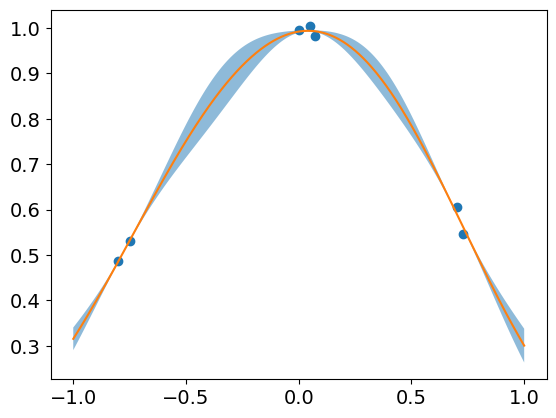

In [34]:
import matplotlib.pyplot as plt

eval_y_gauss = gaussian(params, eval_x)

plt.plot(train_x, train_y, "o")
plt.plot(eval_x, eval_y_gauss)

inv_covariance = jax.hessian(loss_fn)(params)

gradients = jax.jacrev(gaussian)(params, eval_x)

uncertainties_gauss = 0.001 * jax.vmap(calculate_uncertainties, in_axes=(None, 0))(inv_covariance, gradients)

plt.fill_between(eval_x, eval_y_gauss - uncertainties_gauss, eval_y_gauss + uncertainties_gauss, alpha=0.5)

plt.show()



In [35]:
import equinox as eqx
import optax

In [48]:
model = eqx.nn.MLP(in_size=1, out_size=1, width_size=32, depth=2, activation=jax.nn.silu, key=jax.random.PRNGKey(0))
# print(model)

optimizer = optax.adamw(1e-2)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

def loss_fn(model, x, y):
    return jnp.mean((jax.vmap(model)(x) - y)**2)

grad_loss_fn = eqx.filter_jit(eqx.filter_value_and_grad(loss_fn))

def train_step(model, opt_state, train_x, train_y):
    loss, grads = grad_loss_fn(model, train_x, train_y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

for epoch in range(1000):
    loss, model, opt_state = train_step(model, opt_state, train_x[:, None], train_y[:, None])
    if epoch % 100 == 0:
        print("loss:", loss)

loss: 0.74424773
loss: 0.00011896526
loss: 0.00010177459
loss: 9.6766606e-05
loss: 9.167717e-05
loss: 8.6846536e-05
loss: 8.246779e-05
loss: 7.863152e-05
loss: 7.535777e-05
loss: 7.2619914e-05


In [49]:
def last_layer_model(x):
    x = model.layers[0](x)
    x = jax.nn.silu(x)
    x = model.layers[1](x)
    x = jax.nn.silu(x)
    return x

X = jax.vmap(last_layer_model)(train_x[:, None])

# check that the predictions match
assert jnp.allclose(jax.vmap(model.layers[2])(X), jax.vmap(model)(train_x[:, None]))

# Append bias
X = jnp.concatenate([X, jnp.ones((X.shape[0], 1))], axis=1)
XTX = X.T @ X + 1e-3 * jnp.eye(33)

In [50]:
eval_y_nn = jax.vmap(model)(eval_x[:, None])[:, 0]

def calculate_uncertainties(XTX, gradients):
    return gradients @ jnp.linalg.solve(XTX, gradients)

ll_features_x = jnp.concatenate([jax.vmap(last_layer_model)(eval_x[:, None]), jnp.ones((eval_x.shape[0], 1))], axis=1)
uncertainties_nn = 0.02 * jax.vmap(calculate_uncertainties, in_axes=(None, 0))(XTX, ll_features_x)

TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (2,).

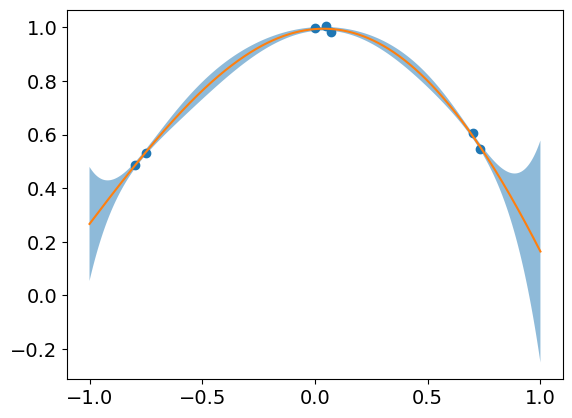

In [51]:
import matplotlib.pyplot as plt

plt.plot(train_x, train_y, "o")
plt.plot(eval_x, eval_y_nn)
plt.fill_between(eval_x, eval_y_nn - uncertainties_nn, eval_y_nn + uncertainties_nn, alpha=0.5)
plt.show()

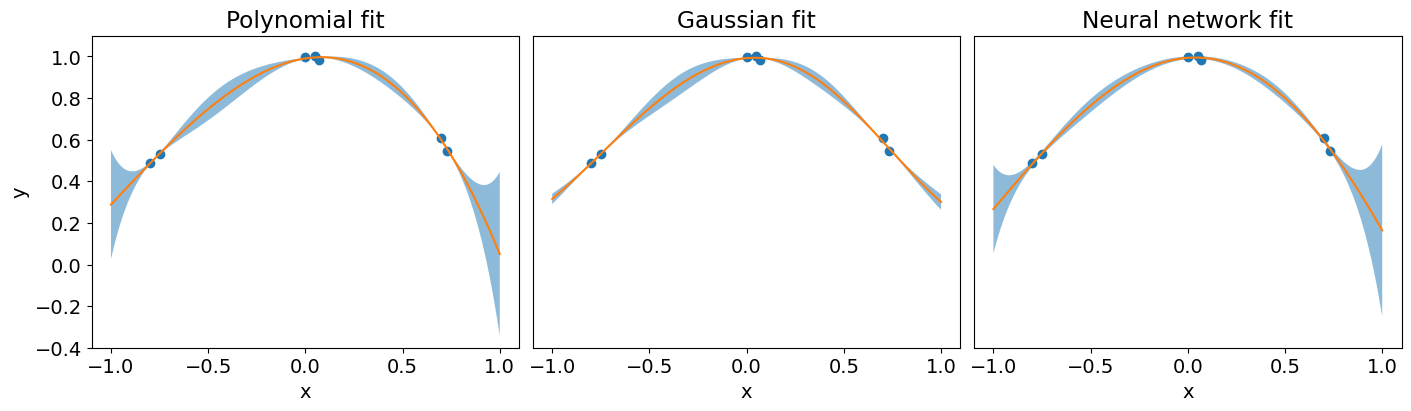

In [40]:
# Plot the three side-by-side

plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(14, 4), constrained_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(train_x, train_y, "o")
ax1.plot(eval_x, eval_y_pol)
ax1.fill_between(eval_x, eval_y_pol - uncertainties_pol, eval_y_pol + uncertainties_pol, alpha=0.5)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Polynomial fit")
ax1.set_ylim(-0.4, 1.1)

ax2.plot(train_x, train_y, "o")
ax2.plot(eval_x, eval_y_gauss)
ax2.fill_between(eval_x, eval_y_gauss - uncertainties_gauss, eval_y_gauss + uncertainties_gauss, alpha=0.5)
ax2.set_yticks([])
ax2.set_xlabel("x")
ax2.set_title("Gaussian fit")
ax2.set_ylim(-0.4, 1.1)

ax3.plot(train_x, train_y, "o")
ax3.plot(eval_x, eval_y_nn)
ax3.fill_between(eval_x, eval_y_nn - uncertainties_nn, eval_y_nn + uncertainties_nn, alpha=0.5)
ax3.set_yticks([])
ax3.set_xlabel("x")
ax3.set_title("Neural network fit")
ax3.set_ylim(-0.4, 1.1)

plt.savefig("toy_fit_comparison.pdf")
plt.show()